In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [10]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


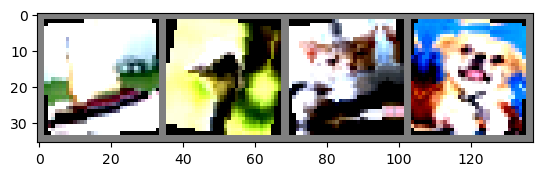

ship  bird  cat   dog  


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [13]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1, stride=2, bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3) , padding=1, stride=2, bias=False),
        ) # output_size = 16/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]          18,432
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

You should consider upgrading via the 'I:\Installs\python.exe -m pip install --upgrade pip' command.


In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5572335720062256 Batch_id=97 Accuracy=34.13: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]



Test set: Average loss: 1.4808, Accuracy: 4542/10000 (45.42%)

EPOCH: 1


Loss=1.3939290046691895 Batch_id=97 Accuracy=48.94: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 1.2309, Accuracy: 5470/10000 (54.70%)

EPOCH: 2


Loss=1.1082093715667725 Batch_id=97 Accuracy=56.39: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s]



Test set: Average loss: 1.1028, Accuracy: 6043/10000 (60.43%)

EPOCH: 3


Loss=1.0099539756774902 Batch_id=97 Accuracy=60.35: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.9782, Accuracy: 6573/10000 (65.73%)

EPOCH: 4


Loss=1.0198757648468018 Batch_id=97 Accuracy=63.42: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]



Test set: Average loss: 0.9605, Accuracy: 6603/10000 (66.03%)

EPOCH: 5


Loss=0.9235271215438843 Batch_id=97 Accuracy=66.13: 100%|██████████| 98/98 [00:17<00:00,  5.55it/s]



Test set: Average loss: 0.8360, Accuracy: 7077/10000 (70.77%)

EPOCH: 6


Loss=0.8259003758430481 Batch_id=97 Accuracy=67.71: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.8384, Accuracy: 7051/10000 (70.51%)

EPOCH: 7


Loss=0.8911172151565552 Batch_id=97 Accuracy=69.00: 100%|██████████| 98/98 [00:17<00:00,  5.54it/s]



Test set: Average loss: 0.7473, Accuracy: 7314/10000 (73.14%)

EPOCH: 8


Loss=0.8696908354759216 Batch_id=97 Accuracy=70.59: 100%|██████████| 98/98 [00:17<00:00,  5.68it/s]



Test set: Average loss: 0.7357, Accuracy: 7470/10000 (74.70%)

EPOCH: 9


Loss=0.7489931583404541 Batch_id=97 Accuracy=71.82: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s]



Test set: Average loss: 0.6928, Accuracy: 7574/10000 (75.74%)

EPOCH: 10


Loss=0.6624415516853333 Batch_id=97 Accuracy=72.84: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.6458, Accuracy: 7790/10000 (77.90%)

EPOCH: 11


Loss=0.7461172342300415 Batch_id=97 Accuracy=73.49: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 0.6422, Accuracy: 7763/10000 (77.63%)

EPOCH: 12


Loss=0.7854366302490234 Batch_id=97 Accuracy=74.71: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.6120, Accuracy: 7869/10000 (78.69%)

EPOCH: 13


Loss=0.776220440864563 Batch_id=97 Accuracy=75.23: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s] 



Test set: Average loss: 0.5852, Accuracy: 7974/10000 (79.74%)

EPOCH: 14


Loss=0.6676800847053528 Batch_id=97 Accuracy=76.22: 100%|██████████| 98/98 [00:17<00:00,  5.55it/s]



Test set: Average loss: 0.5833, Accuracy: 7974/10000 (79.74%)

EPOCH: 15


Loss=0.6034207344055176 Batch_id=97 Accuracy=76.80: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.5916, Accuracy: 7990/10000 (79.90%)

EPOCH: 16


Loss=0.6329149007797241 Batch_id=97 Accuracy=77.57: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]



Test set: Average loss: 0.5418, Accuracy: 8143/10000 (81.43%)

EPOCH: 17


Loss=0.658799409866333 Batch_id=97 Accuracy=77.64: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s] 



Test set: Average loss: 0.5387, Accuracy: 8168/10000 (81.68%)

EPOCH: 18


Loss=0.6878268718719482 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.5180, Accuracy: 8205/10000 (82.05%)

EPOCH: 19


Loss=0.6670734286308289 Batch_id=97 Accuracy=78.74: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.5041, Accuracy: 8267/10000 (82.67%)

EPOCH: 20


Loss=0.6240975856781006 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]



Test set: Average loss: 0.4788, Accuracy: 8355/10000 (83.55%)

EPOCH: 21


Loss=0.5812996029853821 Batch_id=97 Accuracy=79.52: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s] 



Test set: Average loss: 0.4992, Accuracy: 8289/10000 (82.89%)

EPOCH: 22


Loss=0.5776241421699524 Batch_id=97 Accuracy=80.20: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s] 



Test set: Average loss: 0.4858, Accuracy: 8338/10000 (83.38%)

EPOCH: 23


Loss=0.5806297063827515 Batch_id=97 Accuracy=80.30: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s] 



Test set: Average loss: 0.4849, Accuracy: 8342/10000 (83.42%)

EPOCH: 24


Loss=0.5845853090286255 Batch_id=97 Accuracy=80.48: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s] 



Test set: Average loss: 0.4776, Accuracy: 8359/10000 (83.59%)

EPOCH: 25


Loss=0.5143145322799683 Batch_id=97 Accuracy=81.05: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s] 



Test set: Average loss: 0.4659, Accuracy: 8384/10000 (83.84%)

EPOCH: 26


Loss=0.4287291467189789 Batch_id=97 Accuracy=81.30: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s] 



Test set: Average loss: 0.4540, Accuracy: 8419/10000 (84.19%)

EPOCH: 27


Loss=0.4865144193172455 Batch_id=97 Accuracy=81.58: 100%|██████████| 98/98 [00:17<00:00,  5.52it/s] 



Test set: Average loss: 0.4455, Accuracy: 8437/10000 (84.37%)

EPOCH: 28


Loss=0.4983864426612854 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s] 



Test set: Average loss: 0.4611, Accuracy: 8389/10000 (83.89%)

EPOCH: 29


Loss=0.468705952167511 Batch_id=97 Accuracy=81.94: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]  



Test set: Average loss: 0.4412, Accuracy: 8480/10000 (84.80%)

EPOCH: 30


Loss=0.49172741174697876 Batch_id=97 Accuracy=82.23: 100%|██████████| 98/98 [00:17<00:00,  5.54it/s]



Test set: Average loss: 0.4408, Accuracy: 8497/10000 (84.97%)

EPOCH: 31


Loss=0.5086914300918579 Batch_id=97 Accuracy=82.61: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s] 



Test set: Average loss: 0.4291, Accuracy: 8545/10000 (85.45%)

EPOCH: 32


Loss=0.5129307508468628 Batch_id=97 Accuracy=82.71: 100%|██████████| 98/98 [00:17<00:00,  5.51it/s] 



Test set: Average loss: 0.4208, Accuracy: 8548/10000 (85.48%)

EPOCH: 33


Loss=0.5314809083938599 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s] 



Test set: Average loss: 0.4075, Accuracy: 8590/10000 (85.90%)

EPOCH: 34


Loss=0.512964129447937 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s]  



Test set: Average loss: 0.3972, Accuracy: 8607/10000 (86.07%)

EPOCH: 35


Loss=0.5551376342773438 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:17<00:00,  5.64it/s] 



Test set: Average loss: 0.4160, Accuracy: 8578/10000 (85.78%)

EPOCH: 36


Loss=0.4812968075275421 Batch_id=97 Accuracy=83.49: 100%|██████████| 98/98 [00:17<00:00,  5.53it/s] 



Test set: Average loss: 0.4023, Accuracy: 8642/10000 (86.42%)

EPOCH: 37


Loss=0.41458043456077576 Batch_id=97 Accuracy=83.57: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]



Test set: Average loss: 0.4088, Accuracy: 8599/10000 (85.99%)

EPOCH: 38


Loss=0.4869644045829773 Batch_id=97 Accuracy=83.70: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s] 



Test set: Average loss: 0.4286, Accuracy: 8529/10000 (85.29%)

EPOCH: 39


Loss=0.4444027841091156 Batch_id=97 Accuracy=84.00: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s] 



Test set: Average loss: 0.3960, Accuracy: 8649/10000 (86.49%)

EPOCH: 40


Loss=0.5004456639289856 Batch_id=97 Accuracy=83.99: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s] 



Test set: Average loss: 0.3913, Accuracy: 8673/10000 (86.73%)

EPOCH: 41


Loss=0.5202146172523499 Batch_id=97 Accuracy=84.18: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s] 



Test set: Average loss: 0.4127, Accuracy: 8609/10000 (86.09%)

EPOCH: 42


Loss=0.5145465135574341 Batch_id=97 Accuracy=84.26: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s] 



Test set: Average loss: 0.4056, Accuracy: 8622/10000 (86.22%)

EPOCH: 43


Loss=0.44233250617980957 Batch_id=97 Accuracy=84.20: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.3900, Accuracy: 8670/10000 (86.70%)

EPOCH: 44


Loss=0.4462079107761383 Batch_id=97 Accuracy=84.53: 100%|██████████| 98/98 [00:17<00:00,  5.64it/s] 



Test set: Average loss: 0.3783, Accuracy: 8712/10000 (87.12%)

EPOCH: 45


Loss=0.42476850748062134 Batch_id=97 Accuracy=84.85: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]



Test set: Average loss: 0.3964, Accuracy: 8675/10000 (86.75%)

EPOCH: 46


Loss=0.4358817934989929 Batch_id=97 Accuracy=84.84: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s] 



Test set: Average loss: 0.3883, Accuracy: 8698/10000 (86.98%)

EPOCH: 47


Loss=0.3639569878578186 Batch_id=97 Accuracy=84.90: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s] 



Test set: Average loss: 0.3939, Accuracy: 8666/10000 (86.66%)

EPOCH: 48


Loss=0.4747036099433899 Batch_id=97 Accuracy=84.92: 100%|██████████| 98/98 [00:17<00:00,  5.53it/s] 



Test set: Average loss: 0.3924, Accuracy: 8676/10000 (86.76%)

EPOCH: 49


Loss=0.3899494409561157 Batch_id=97 Accuracy=85.10: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s] 



Test set: Average loss: 0.3839, Accuracy: 8706/10000 (87.06%)

